In [35]:
import numpy as np
import matplotlib.pyplot as plt
from inktime import rgbkm
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import cv2

# Edge detection

#### Di-Zenzo color gradient formulation

Calculating the gradients using the Sobel kernels. These can be decomposed as the products of an averaging and a differentiation kernel, they compute the gradient with smoothing. Calculate the gradient of the image ($I$) in each channel both in the x and y direction. Use pythogoras to calculate total gradient. The edges are were the gradient is above a certain threshold.

$ \lVert \nabla I(x,y) \rVert =\sqrt{\sum_{c \in \{L,a,b\}} \left(\left( \frac{\partial I_c}{\partial x} \right)^2+\left( \frac{\partial I_c}{\partial y} \right)^2\right)}$

I calculate the gradients in Lab space because distances there represent perceived color distances more accurately than RGB. I assume daylight D65.

In [39]:

def sobel_gradient(img_rgb, ksize=3, sigma = 0.5):
    """
    Lab vector gradient magnitude.

    Parameters:
    img_rgb : Input RGB image (H, W, 3) uint8
    ksize : Sobel kernel size int (3-5)
    threshold : Threshold in [0,1] after normalization

    Returns:
    magnitude : Gradient magnitude (H, W) float32
    """

    # RGB -> Lab (OpenCV uses D65, sobel needs floating points)
    # Each point is a vector in R^3
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
    lab = cv2.GaussianBlur(lab, (0, 0), sigma)

    # Compute spatial gradients per channel c = l, a, b
    gx = np.zeros(lab.shape[:2], dtype=np.float32) # gradient in x direction
    gy = np.zeros(lab.shape[:2], dtype=np.float32) # gradient in y direction

    for c in range(3):
        gx_c = cv2.Sobel(lab[:, :, c], cv2.CV_32F, 1, 0, ksize=ksize)
        gy_c = cv2.Sobel(lab[:, :, c], cv2.CV_32F, 0, 1, ksize=ksize)
        gx += gx_c 
        gy += gy_c 

    # Vector gradient magnitude
    magnitude = np.sqrt(gx**2 + gy**2)

    # Vector gradient direction
    direction = np.arctan2(gy, gx)

    # Normalize gradient magnitude
    magnitude /= magnitude.max() + 1e-8

    return magnitude, direction

def non_max_suppression(mag, theta):
    H, W = mag.shape
    out = np.zeros_like(mag, dtype=np.float32) 

    # Convert angle to degrees
    angle = np.rad2deg(theta) % 180 #gradient is symmetric (0 deg = 180 deg direction)

    # Loop over all pixels
    for i in range(1, H-1): # skip border pixels
        for j in range(1, W-1):
            q = r = 0

            # Quantize directions to 4 sectors
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180): # 0 deg / horizontal 
                q = mag[i, j+1]
                r = mag[i, j-1]
            elif (22.5 <= angle[i,j] < 67.5): # 45 deg /  diagonal 
                q = mag[i+1, j-1]
                r = mag[i-1, j+1]
            elif (67.5 <= angle[i,j] < 112.5): # 90 deg / vertical
                q = mag[i+1, j]
                r = mag[i-1, j]
            elif (112.5 <= angle[i,j] < 157.5): # 135 deg / diagonal
                q = mag[i-1, j-1]
                r = mag[i+1, j+1]

            if mag[i,j] >= q and mag[i,j] >= r: # if pixel has a larger maximum than its two neigbors, keep pixel otherwise zero
                out[i,j] = mag[i,j]

    return out




#### Non-maximum suppression 

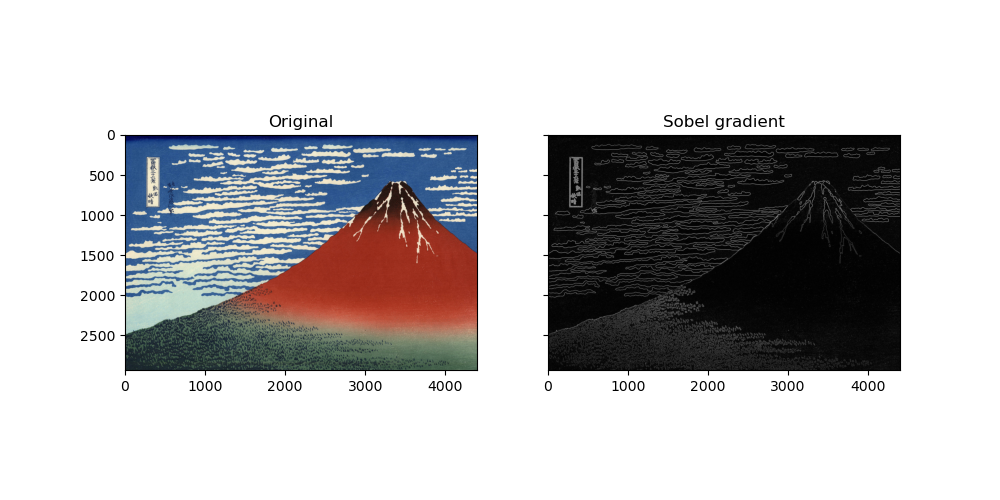

In [42]:
%matplotlib widget

img = cv2.imread('red_fuji3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mag, angle = sobel_gradient(img, sigma = 1.5)

plt.close()
fig, ax = plt.subplots(1,2, figsize = (10,5), sharex = True, sharey = True)

ax[0].set_title("Original")
ax[0].imshow(img)

ax[1].set_title("Sobel gradient")
ax[1].imshow(mag, cmap = 'gray')

plt.show()

In [43]:
nms_mag = non_max_suppression(mag, angle)

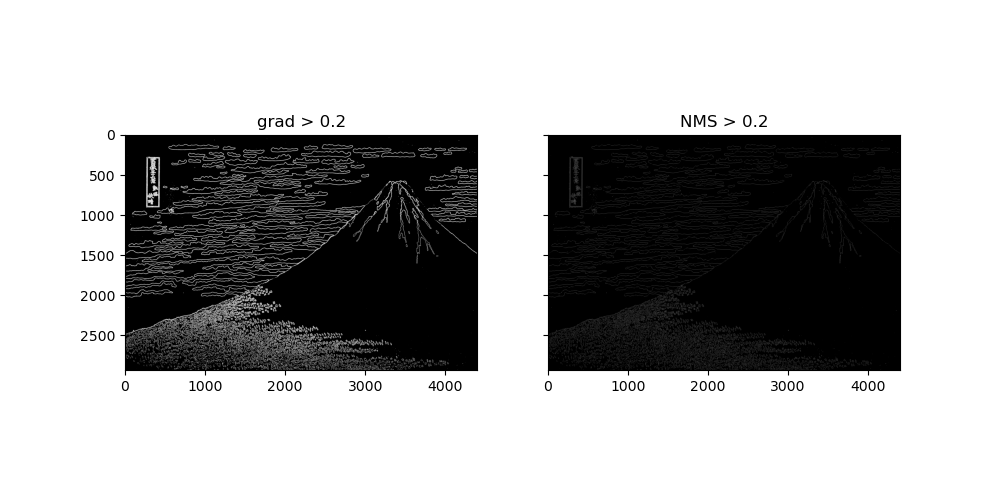

In [44]:
thresh = 0.2
thresh_nms = 0.2

plt.close()
fig, ax = plt.subplots(1,2, figsize = (10,5), sharex = True, sharey = True)
ax[0].set_title(f"grad > {thresh}")
ax[0].imshow(mag>thresh, cmap = 'gray')
ax[1].set_title(f"NMS > {thresh_nms}")
ax[1].imshow(nms_mag>thresh_nms, cmap = 'gray')
plt.show()

#### Canny edge detection on sobel magnitude

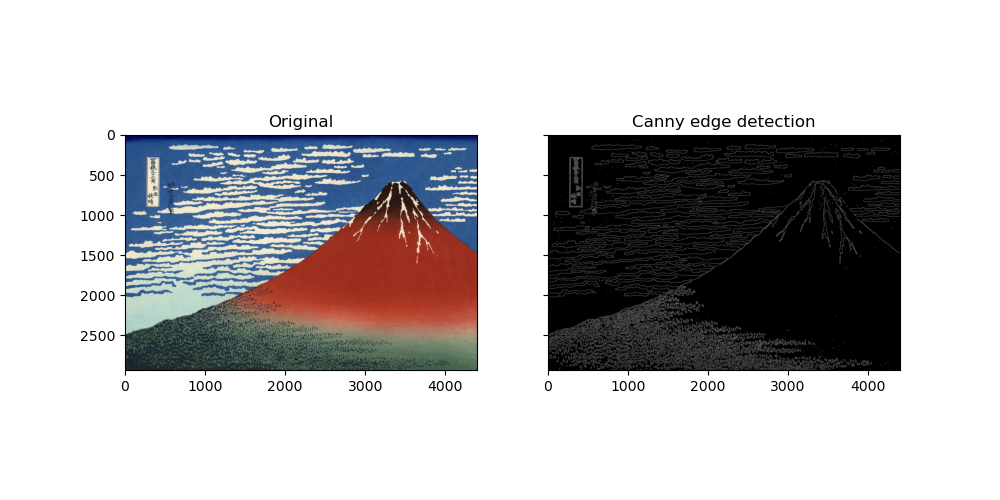

In [48]:
%matplotlib widget

lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float32)
blur = cv2.GaussianBlur(mag*255, (0, 0), 1.5).astype(np.uint8)

v = np.median(blur)
lower = 5.5 * v
upper = 6.5 * v
edges = cv2.Canny(blur, lower, upper, L2gradient=True) 

plt.close()
fig, ax = plt.subplots(1,2, figsize = (10,5), sharex = True, sharey = True)
ax[0].set_title("Original")
ax[0].imshow(img, cmap = 'gray')
ax[1].set_title("Canny edge detection")
ax[1].imshow(edges, cmap = 'gray')
plt.show()

#### Canny edge detection on lab image

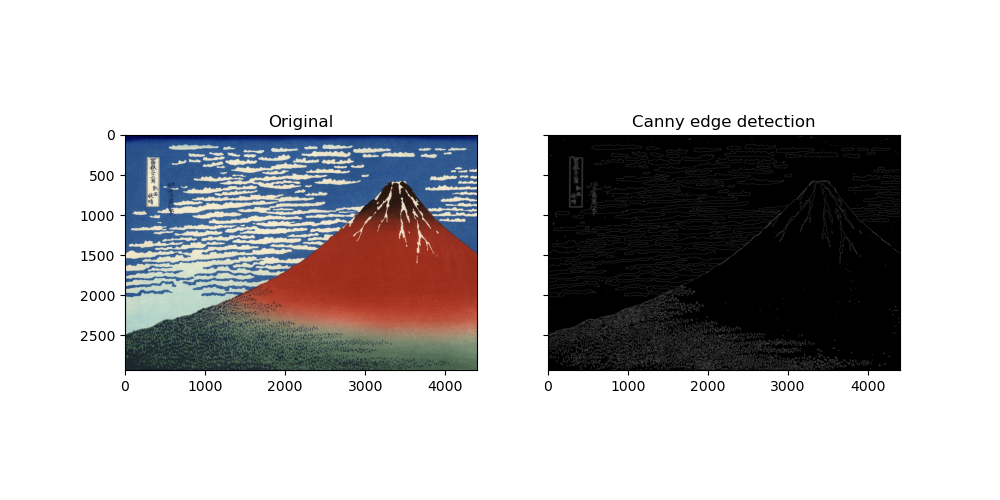

In [24]:
lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float32)
blur = cv2.GaussianBlur(lab, (0, 0), 1.5).astype(np.uint8)

v = np.median(blur)
lower = 0.2 * v
upper = 0.7 * v

edges = cv2.Canny(blur, lower, upper, L2gradient=True) 

plt.close()
fig, ax = plt.subplots(1,2, figsize = (10,5), sharex = True, sharey = True)
ax[0].set_title("Original")
ax[0].imshow(img, cmap = 'gray')
ax[1].set_title("Canny edge detection")
ax[1].imshow(edges, cmap = 'gray')
plt.show()

#### Second derivative == 0

In [27]:
def derivatives(img_rgb, ksize=3, sigma=0.5):

    # convert to lab
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB).astype(np.float32) 
    lab = cv2.GaussianBlur(lab, (0,0), sigma)

    Ix = np.zeros(lab.shape[:2], np.float32) # dI/dx
    Iy = np.zeros(lab.shape[:2], np.float32) # dI/dy

    Ixx = np.zeros(lab.shape[:2], np.float32) #d^2I/dx^2
    Iyy = np.zeros(lab.shape[:2], np.float32) #d^2I/dy^2
    Ixy = np.zeros(lab.shape[:2], np.float32) #d^2I/dxy

    for c in range(3):

        L = lab[:,:,c]

        # Gradient = first derivative
        Ix_c  = cv2.Sobel(L, cv2.CV_32F, 1, 0, ksize=ksize)
        Iy_c  = cv2.Sobel(L, cv2.CV_32F, 0, 1, ksize=ksize)

        # second derivatives
        Ixx_c = cv2.Sobel(L, cv2.CV_32F, 2, 0, ksize=ksize)
        Iyy_c = cv2.Sobel(L, cv2.CV_32F, 0, 2, ksize=ksize)
        Ixy_c = cv2.Sobel(L, cv2.CV_32F, 1, 1, ksize=ksize)

        Ix  += Ix_c
        Iy  += Iy_c
        Ixx += Ixx_c
        Iyy += Iyy_c
        Ixy += Ixy_c

    return Ix, Iy, Ixx, Iyy, Ixy


def directional_second_derivative(Ix, Iy, Ixx, Iyy, Ixy):

    eps = 1e-8

    mag = np.sqrt(Ix**2 + Iy**2) # gradient magnitude

    # normalized x and y components of the gradient
    nx = Ix / (mag + eps) 
    ny = Iy / (mag + eps)

    # normalize gradient magnitude
    mag = mag / (mag.max() + 1e-8)

    # n^T H n: directional second derivative (second derivative along gradient direction)
    Dnn = nx*nx*Ixx + 2*nx*ny*Ixy + ny*ny*Iyy

    return Dnn, mag

from scipy import ndimage as ndi
from skimage.morphology import remove_small_objects, binary_closing

def zero_crossing(Dnn, mag, mag_thresh=0.1):
    # Calculate DnnI = 0 
    
    # sign change
    sign_change = np.logical_or(
        Dnn * np.roll(Dnn, 1, axis=0) < 0, # vertical zero crossing
        Dnn * np.roll(Dnn, 1, axis=1) < 0  # horizontal zero crossing
    )

    # keep only where gradient strong
    edges = sign_change & (mag > mag_thresh)
    edges = remove_small_objects(edges, min_size=4)
    #edges = binary_closing(edges, footprint=np.ones((2,2)))

    return edges


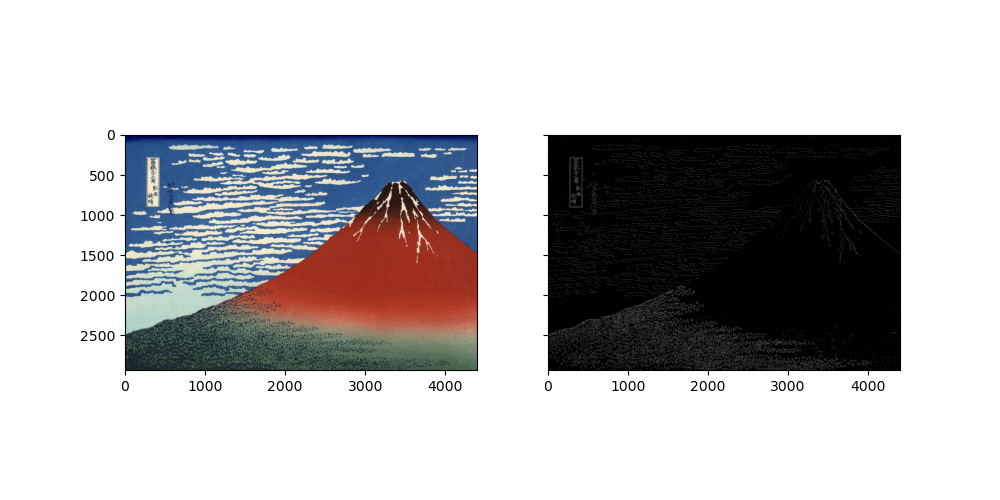

In [29]:
Ix, Iy, Ixx, Iyy, Ixy = derivatives(img, sigma = 2)
Dnn, mag = directional_second_derivative(Ix, Iy, Ixx, Iyy, Ixy)
edges2 = zero_crossing(Dnn, mag, mag_thresh=0.1)


plt.close()
fig, ax = plt.subplots(1,2, figsize = (10,5), sharex = True, sharey = True)
ax[0].imshow(img)
ax[1].imshow(edges2, cmap = 'gray')
plt.show()



### Watershed + merge regions based on color

In [142]:
from scipy.ndimage import gaussian_filter, distance_transform_edt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.morphology import h_minima
from skimage.segmentation import felzenszwalb

def watershed_gradient(gradient,
    grad_threshold=0.15,
    min_distance=1,
    distance_threshold=1,
    min_region_size=1
    ):
    
    """
    Watershed segmentation from a gradient magnitude image.
    """
    
    # Define barriers (high gradient = boundary)
    barriers = gradient > grad_threshold

    # Distance transform from barriers
    distance = distance_transform_edt(~barriers)

    # Extract markers from distance peaks
    coords = peak_local_max(distance, min_distance=min_distance, threshold_abs=distance_threshold)

    markers = np.zeros(distance.shape, dtype=np.int32)
    for i, (y, x) in enumerate(coords, start=1):
        markers[y, x] = i

    # Watershed flooding
    labels = watershed(gradient, markers, watershed_line=False)

    return labels, distance


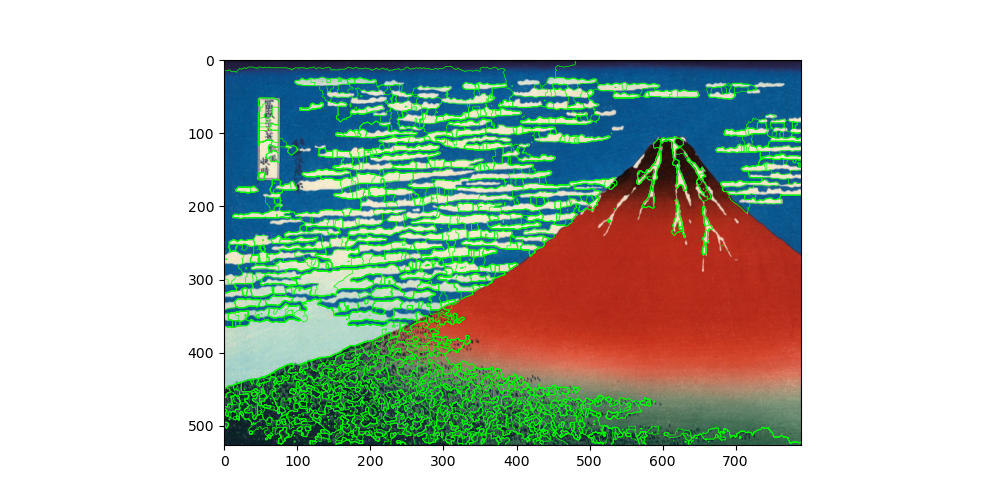

In [304]:
labels, distance = watershed_gradient(mag)
plt.close()

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.imshow(img)
ax.contour(labels, colors='lime', linewidths=0.5)
plt.show()

In [146]:
from skimage import graph
from skimage.color import rgb2lab

def merge_similar_regions(img_rgb, labels, color_thresh=15.0):

    lab = rgb2lab(img_rgb)

    # Build region adjacency graph (RAG)
    rag = graph.rag_mean_color(lab, labels)

    # Merge if color distance small
    labels_merged = graph.cut_threshold(labels, rag, thresh=color_thresh)

    return labels_merged


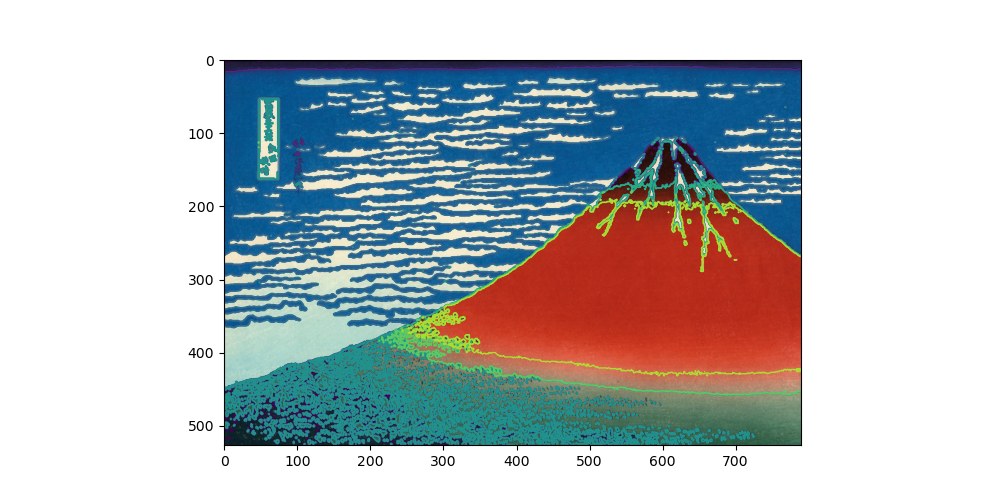

In [300]:
labels_merged = merge_similar_regions(img, labels)

plt.close()
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.imshow(img)
ax.contour(labels_merged, linewidths=1)
plt.show()

### Felzenswalb of zo

In [151]:
from skimage.segmentation import felzenszwalb

def felzenszwalb_lab(img_rgb, scale=150, sigma=0.8, min_size=100):

    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)

    labels = felzenszwalb(
        lab,
        scale=scale,
        sigma=sigma,
        min_size=min_size
    )

    return labels

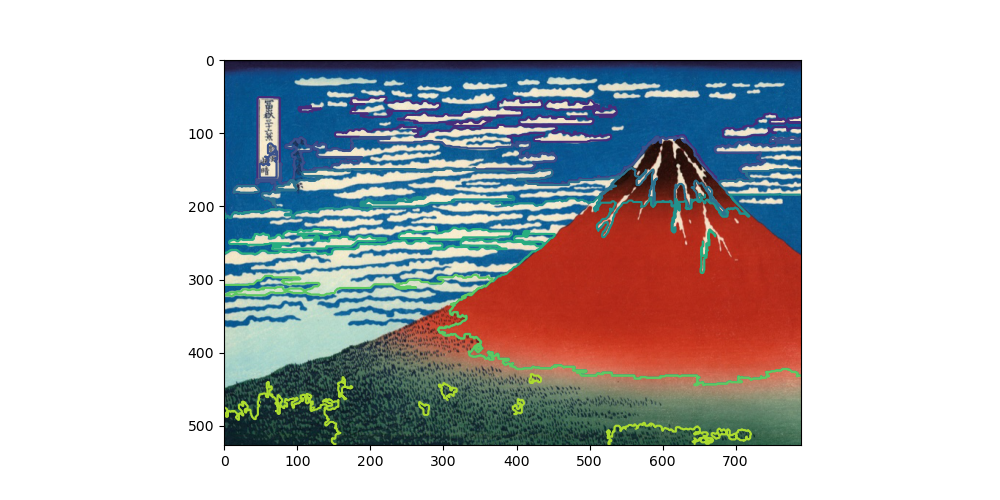

In [306]:
labels = felzenszwalb_lab(img)

plt.close()
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.imshow(img)
ax.contour(labels)
plt.show()

## Back to K-means/ clustering

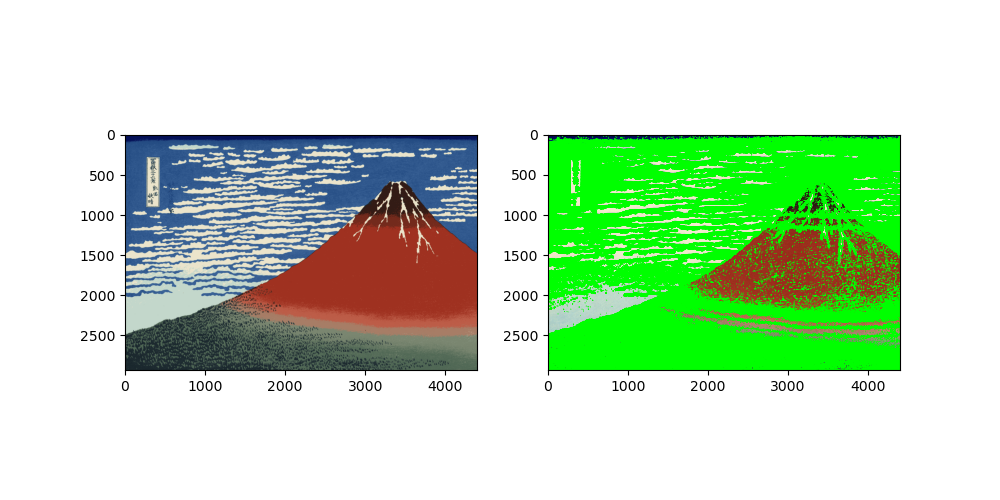

In [33]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage.color import rgb2lab, label2rgb
from skimage.filters import sobel
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

image_lab = lab
h, w, _ = img.shape

grad, direction = sobel_gradient(img) # compute gradient

yy, xx = np.mgrid[0:h, 0:w] # spatial grid

lambda_s = 0.0    # spatial weight
lambda_c = 1.0     # color weight
lambda_g = 10.0      # edge weight

features = np.stack([
    #lambda_s * xx,
    #lambda_s * yy,
    lambda_c * image_lab[:, :, 0],
    lambda_c * image_lab[:, :, 1],
    lambda_c * image_lab[:, :, 2],
    #lambda_g * grad
], axis=-1)

# Flatten to (N_pixels, N_features)
X = features.reshape(-1, 3)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#K-means
n_clusters = 15   # adjust

kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
labels = kmeans.fit_predict(X_scaled)
labels = labels.reshape(h, w)

def region_median_color(image, labels):
    out = np.zeros_like(image)
    for label in np.unique(labels):
        mask = labels == label
        for c in range(3):
            out[:, :, c][mask] = np.median(image[:, :, c][mask])
    return out

segmented = region_median_color(img, labels)

plt.close()
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(segmented)
ax[1].imshow(img)
ax[1].contour(labels, colors='lime', linewidths=0.5)
plt.show()



### Toch maar UMAP...

nope nope nope, duurt te lang en geeft geen zinnig resultaat

In [ ]:
h, w, _ = img.shape

image_lab = rgb2lab(img) # from RGB to Lab
grad = sobel_gradient(img) # compute gradient

yy, xx = np.mgrid[0:h, 0:w] # spatial grid

features = np.stack([xx, yy, image_lab[:, :, 0], image_lab[:, :, 1], image_lab[:, :, 2]], axis=-1)

# Flatten to (N_pixels, N_features)
features_flat = features.reshape(-1, 5)

import umap

reducer = umap.UMAP(n_neighbors=50, min_dist=0.0, n_components=2, random_state=42)
embedding = reducer.fit_transform(features_flat)




In [ ]:
colors = img.reshape(-1, 3) / 255.0

plt.close()
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.scatter(embedding[:, 0], embedding[:, 1], s = .5, c = colors)

plt.show()

In [ ]:
h, w, _ = img.shape

image_lab = rgb2lab(img) # from RGB to Lab

features = np.stack([image_lab[:, :, 0], image_lab[:, :, 1], image_lab[:, :, 2]], axis=-1)

# Flatten to (N_pixels, N_features)
features_flat = features.reshape(-1, 3)
noise = 1e-6 * np.random.randn(*features_flat.shape)
features_flat_noisy = features_flat + noise

reducer = umap.UMAP(n_neighbors=100, min_dist=0.0, n_components=2, init = 'random', random_state=42)
embedding = reducer.fit_transform(features_flat_noisy)

In [ ]:
colors = img.reshape(-1, 3) / 255.0

plt.close()
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.scatter(embedding[:, 0], embedding[:, 1], s = .5, c = colors)

plt.show()